# Hypothese 3

In [28]:
import ast
import json
import pickle
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from scipy import stats

## Daten einlesen

In [15]:
parquet_file = "data/input/Data_OpenAlex.parquet"

df_openalex = pd.read_parquet(parquet_file, engine='pyarrow')
print(f"Parquet-Datei erfolgreich geladen. Shape: {df_openalex.shape}")
print(f"Verfügbare Spalten: {list(df_openalex.columns)}")
print("\nErste 3 Zeilen der institutions-Spalte:")
print(df_openalex['institutions'].head(3))

Parquet-Datei erfolgreich geladen. Shape: (16751942, 9)
Verfügbare Spalten: ['paper_id', 'doi', 'fwci', 'title', 'publication_year', 'cited_by_count', 'institution_count', 'country_codes', 'institutions']

Erste 3 Zeilen der institutions-Spalte:
0    [{"id": "I42237331", "name": "Centre internati...
1    [{"id": "I1297363086", "name": "St. Michael's ...
2    [{"id": "I4210109182", "name": "Momenta Pharma...
Name: institutions, dtype: object


In [16]:
elite_unis = pd.read_csv("data/input/elite_unis_overall.csv")
elite_unis.head()

,University
0,Technical University of Munich
1,Ludwig-Maximilians-Universität München
2,Université Paris Sciences et Lettres
3,KU Leuven
4,Heidelberg University


## Analyse Elite vs Nicht-Elite Universitäten

In [17]:
analysis_df = None
elite_fwci_values = None
non_elite_fwci_values = None

# Bestimme die richtige Spalte für Elite-Unis
if 'University' in elite_unis.columns:
    elite_col = 'University'
elif 'institution' in elite_unis.columns:
    elite_col = 'institution'
elif 'university' in elite_unis.columns:
    elite_col = 'university'
else:
    elite_col = elite_unis.columns[0]

# Erstelle Set für schnellen Lookup (exakte Namen)
elite_university_names = set(elite_unis[elite_col].str.strip())
print(f"   Elite-Universitäten geladen: {len(elite_university_names)}")
print(f"   Verwendete Spalte: '{elite_col}'")
print(f"   Beispiele:")
for i, name in enumerate(list(elite_university_names)[:10]):
    print(f"   {i+1:2d}. {name}")

   Elite-Universitäten geladen: 50
   Verwendete Spalte: 'University'
   Beispiele:
    1. Erasmus University Rotterdam
    2. KTH Royal Institute of Technology
    3. Institut Polytechnique de Paris
    4. Lund University
    5. KU Leuven
    6. University of Vienna
    7. Technical University of Berlin
    8. Karlsruhe Institute of Technology
    9. Universitat Pompeu Fabra
   10. Trinity College Dublin


In [18]:
def generate_analysis_df(df_openalex):
    print(f"Gesamtanzahl Papers: {df_openalex.shape[0]:,}")

    # Listen für Ergebnisse
    elite_papers = []
    non_elite_papers = []

    # Zähler für Statistiken
    total_processed = 0
    papers_with_institutions = 0
    papers_with_fwci = 0
    parsing_errors = 0

    # Iteriere durch alle Papers udn kategorisiere sie
    for idx, row in df_openalex.iterrows():
        total_processed += 1
        
        # Progress Update
        if total_processed % 10000 == 0:
            print(f"     Verarbeitet: {total_processed:,} | Elite: {len(elite_papers)} | Nicht-Elite: {len(non_elite_papers)}")
        
        # Prüfe ob FWCI vorhanden ist
        fwci_score = None
        if 'fwci' in row and pd.notna(row['fwci']):
            fwci_score = float(row['fwci'])
            papers_with_fwci += 1
        elif 'FWCI' in row and pd.notna(row['FWCI']):
            fwci_score = float(row['FWCI'])
            papers_with_fwci += 1
        
        # Überspringe Papers ohne FWCI
        if fwci_score is None:
            continue
        
        # Extrahiere Institutionen
        institutions_data = row.get('institutions', None)
        if pd.isna(institutions_data):
            continue
        
        papers_with_institutions += 1
        
        try:
            # Parse institutions JSON/List
            if isinstance(institutions_data, str):
                institutions_list = json.loads(institutions_data)
            elif isinstance(institutions_data, list):
                institutions_list = institutions_data
            else:
                institutions_list = ast.literal_eval(str(institutions_data))
            
            # Extrahiere alle Institutionsnamen
            paper_institutions = set()
            for institution in institutions_list:
                if isinstance(institution, dict):
                    # Versuche verschiedene Namensfelder
                    name = None
                    if 'display_name' in institution:
                        name = institution['display_name'].strip()
                    elif 'name' in institution:
                        name = institution['name'].strip()
                    
                    if name:
                        paper_institutions.add(name)
            
            # Prüfe ob mindestens eine Institution eine Elite-Uni ist
            is_elite = bool(paper_institutions.intersection(elite_university_names))
            
            # Ergebnis zusammenstellen
            paper_data = {
                'paper_id': idx,
                'fwci': fwci_score,
                'institutions': list(paper_institutions),
                'is_elite': is_elite
            }
            
            if is_elite:
                # Finde welche Elite-Unis beteiligt waren
                elite_institutions_in_paper = paper_institutions.intersection(elite_university_names)
                paper_data['elite_institutions'] = list(elite_institutions_in_paper)
                elite_papers.append(paper_data)
            else:
                non_elite_papers.append(paper_data)
                
        except Exception as e:
            parsing_errors += 1
            continue
    
    print(f"Gesamte Papers verarbeitet: {total_processed:,}")
    print(f"Papers mit Institutionen: {papers_with_institutions:,}")
    print(f"Papers mit FWCI: {papers_with_fwci:,}")
    print(f"Parsing-Fehler: {parsing_errors}")
    print(f"Elite Papers: {len(elite_papers):,}")
    print(f"Nicht-Elite Papers: {len(non_elite_papers):,}")

    # Elite DataFrame
    elite_df = pd.DataFrame([
        {'Institution': 'Elite-Institution', 'FWCI': paper['fwci'], 'paper_id': paper['paper_id']}
        for paper in elite_papers
    ])

    # Nicht-Elite DataFrame
    non_elite_df = pd.DataFrame([
        {'Institution': 'Sonstige Institution', 'FWCI': paper['fwci'], 'paper_id': paper['paper_id']}
        for paper in non_elite_papers
    ])

    # Kombiniere beide DataFrames
    analysis_df = pd.concat([elite_df, non_elite_df], ignore_index=True)

    print(f"Elite Dataframe: {len(elite_df):,} Papers")
    print(f"Nicht-Elite Dataframe: {len(non_elite_df):,} Papers")
    print(f"Kombiniert: {len(analysis_df):,} Papers")

    with open("data/cache/hypothese3_analysis_elite_non_elite.pkl", "wb") as f:
        pickle.dump([analysis_df, elite_papers, non_elite_papers], f)

    return analysis_df, elite_papers, non_elite_papers

In [19]:
# Check if cached file exists otherwise generate it
try:
    with open("data/cache/hypothese3_analysis_elite_non_elite.pkl", "rb") as f:
        analysis_df, elite_papers, non_elite_papers = pickle.load(f)
    print("Cache geladen.")
except FileNotFoundError:
    print("Cache nicht gefunden, generiere Analyse DataFrame")
    analysis_df, elite_papers, non_elite_papers = generate_analysis_df(df_openalex)

Cache nicht gefunden, generiere Analyse DataFrame
Gesamtanzahl Papers: 16,751,942
     Verarbeitet: 10,000 | Elite: 2925 | Nicht-Elite: 6882
     Verarbeitet: 20,000 | Elite: 5544 | Nicht-Elite: 14118
     Verarbeitet: 30,000 | Elite: 8156 | Nicht-Elite: 21357
     Verarbeitet: 40,000 | Elite: 10759 | Nicht-Elite: 28606
     Verarbeitet: 50,000 | Elite: 13191 | Nicht-Elite: 36047
     Verarbeitet: 60,000 | Elite: 15679 | Nicht-Elite: 43435
     Verarbeitet: 70,000 | Elite: 18115 | Nicht-Elite: 50862
     Verarbeitet: 80,000 | Elite: 20555 | Nicht-Elite: 58286
     Verarbeitet: 90,000 | Elite: 22952 | Nicht-Elite: 65747
     Verarbeitet: 100,000 | Elite: 25447 | Nicht-Elite: 73106
     Verarbeitet: 110,000 | Elite: 27783 | Nicht-Elite: 80618
     Verarbeitet: 120,000 | Elite: 30043 | Nicht-Elite: 88217
     Verarbeitet: 130,000 | Elite: 32394 | Nicht-Elite: 95699
     Verarbeitet: 140,000 | Elite: 34716 | Nicht-Elite: 103254
     Verarbeitet: 150,000 | Elite: 37012 | Nicht-Elite: 110813

In [20]:
# Zusammenfassung der Statistiken

# Erstelle die FWCI-Listen für die Analyse
elite_fwci_values = [paper['fwci'] for paper in elite_papers]
non_elite_fwci_values = [paper['fwci'] for paper in non_elite_papers]

print(f"Elite Institutionen:")
print(f"     Anzahl Papers: {len(elite_fwci_values):,}")
print(f"     FWCI Mittelwert: {np.mean(elite_fwci_values):.3f}")
print(f"     FWCI Median: {np.median(elite_fwci_values):.3f}")
print(f"     FWCI Standardabweichung: {np.std(elite_fwci_values):.3f}")
print(f"     FWCI Min: {np.min(elite_fwci_values):.3f}")
print(f"     FWCI Max: {np.max(elite_fwci_values):.3f}")

Elite Institutionen:
     Anzahl Papers: 2,098,210
     FWCI Mittelwert: 2.421
     FWCI Median: 0.948
     FWCI Standardabweichung: 8.260
     FWCI Min: 0.000
     FWCI Max: 2503.439


In [21]:
print(f"Nicht-Elite Institutionen:")
print(f"     Anzahl Papers: {len(non_elite_fwci_values):,}")
print(f"     FWCI Mittelwert: {np.mean(non_elite_fwci_values):.3f}")
print(f"     FWCI Median: {np.median(non_elite_fwci_values):.3f}")
print(f"     FWCI Standardabweichung: {np.std(non_elite_fwci_values):.3f}")
print(f"     FWCI Min: {np.min(non_elite_fwci_values):.3f}")
print(f"     FWCI Max: {np.max(non_elite_fwci_values):.3f}")

Nicht-Elite Institutionen:
     Anzahl Papers: 12,379,617
     FWCI Mittelwert: 1.489
     FWCI Median: 0.371
     FWCI Standardabweichung: 6.558
     FWCI Min: 0.000
     FWCI Max: 8154.949


In [22]:
print(f"Vergleich:")
difference = np.mean(elite_fwci_values) - np.mean(non_elite_fwci_values)
print(f"     Differenz Mittelwerte: {difference:.3f}")
print(f"     Prozentuale Differenz: {(difference / np.mean(non_elite_fwci_values) * 100):.1f}%")

Vergleich:
     Differenz Mittelwerte: 0.932
     Prozentuale Differenz: 62.6%


In [23]:
# Häufigste Elite-Institutionen
print(f"Höufigste Elite-Institutionen in den Papern")
elite_inst_counter = defaultdict(int)
for paper in elite_papers:
    for inst in paper.get('elite_institutions', []):
        elite_inst_counter[inst] += 1

sorted_elite_insts = sorted(elite_inst_counter.items(), key=lambda x: x[1], reverse=True)
for i, (inst, count) in enumerate(sorted_elite_insts[:15], 1):
    print(f"   {i:2d}. {inst}: {count:,} Papers")

Höufigste Elite-Institutionen in den Papern
    1. Sorbonne Université: 117,783 Papers
    2. Université Paris Cité: 114,155 Papers
    3. KU Leuven: 112,719 Papers
    4. Heidelberg University: 99,207 Papers
    5. University of Copenhagen: 97,405 Papers
    6. Technical University of Munich: 84,533 Papers
    7. Ludwig-Maximilians-Universität München: 81,901 Papers
    8. Karolinska Institutet: 77,944 Papers
    9. University of Bologna: 76,388 Papers
   10. Universität Hamburg: 75,472 Papers
   11. University of Amsterdam: 74,192 Papers
   12. Radboud University Nijmegen: 71,274 Papers
   13. Lund University: 69,907 Papers
   14. University of Helsinki: 69,620 Papers
   15. Aarhus University: 69,510 Papers


## Visualisierung

In [25]:
print(f"Variablen für Analyse gesetzt:")
print(f"   - analysis_df: {len(analysis_df)} Zeilen")
print(f"   - elite_fwci_values: {len(elite_fwci_values)} Werte")
print(f"   - non_elite_fwci_values: {len(non_elite_fwci_values)} Werte")
print(f"   Elite Papers: {len(elite_fwci_values):,}")
print(f"   Nicht-Elite Papers: {len(non_elite_fwci_values):,}")
print(f"   Gesamte Datenpunkte: {len(analysis_df):,}")

Variablen für Analyse gesetzt:
   - analysis_df: 14477827 Zeilen
   - elite_fwci_values: 2098210 Werte
   - non_elite_fwci_values: 12379617 Werte
   Elite Papers: 2,098,210
   Nicht-Elite Papers: 12,379,617
   Gesamte Datenpunkte: 14,477,827


In [29]:
# Matplotlib Einstellungen
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Helvetica']

# Verwende einen anderen Style, falls seaborn-v0_8-whitegrid nicht verfügbar ist
try:
    mpl.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        mpl.style.use('seaborn-whitegrid')
    except:
        mpl.style.use('default')

In [94]:
# Datenbereinigung: Entferne extreme Ausreißer für bessere Visualisierung
def remove_extreme_outliers(data, threshold=99.5):
    """Entferne die extremsten Ausreißer (oberste 0.5%)"""
    percentile = np.percentile(data, threshold)
    return [x for x in data if x <= percentile]

In [95]:
# Originaldaten für Statistiken behalten
original_elite = elite_fwci_values.copy()
original_non_elite = non_elite_fwci_values.copy()

# Bereinigte Daten für Visualisierung
elite_cleaned = remove_extreme_outliers(elite_fwci_values)
non_elite_cleaned = remove_extreme_outliers(non_elite_fwci_values)

print(f"Datenbereinigung:")
print(f"   Elite: {len(original_elite):,} → {len(elite_cleaned):,} ({len(original_elite)-len(elite_cleaned)} extreme Ausreißer entfernt)")
print(f"   Nicht-Elite: {len(original_non_elite):,} → {len(non_elite_cleaned):,} ({len(original_non_elite)-len(non_elite_cleaned)} extreme Ausreißer entfernt)")

Datenbereinigung:
   Elite: 2,098,210 → 2,087,718 (10492 extreme Ausreißer entfernt)
   Nicht-Elite: 12,379,617 → 12,317,720 (61897 extreme Ausreißer entfernt)


In [96]:
# DataFrame für bereinigten Plot erstellen
plot_df = pd.DataFrame({
    'Institution': ['Elite-Institution']*len(elite_cleaned) + ['Sonstige Institution']*len(non_elite_cleaned),
    'FWCI': elite_cleaned + non_elite_cleaned,
    'Kategorie': ['Anzahl der Paper'] * (len(elite_cleaned) + len(non_elite_cleaned))
})

# Berechne Durchschnittswerte für die bereinigten Daten
elite_mean = np.mean(elite_cleaned)
non_elite_mean = np.mean(non_elite_cleaned)

print(f"Durchschnittswerte (bereinigte Daten):")
print(f"   Elite-Institution: {elite_mean:.3f}")
print(f"   Sonstige Institution: {non_elite_mean:.3f}")
print(f"   Differenz: {elite_mean - non_elite_mean:.3f}")

Durchschnittswerte (bereinigte Daten):
   Elite-Institution: 2.079
   Sonstige Institution: 1.266
   Differenz: 0.813


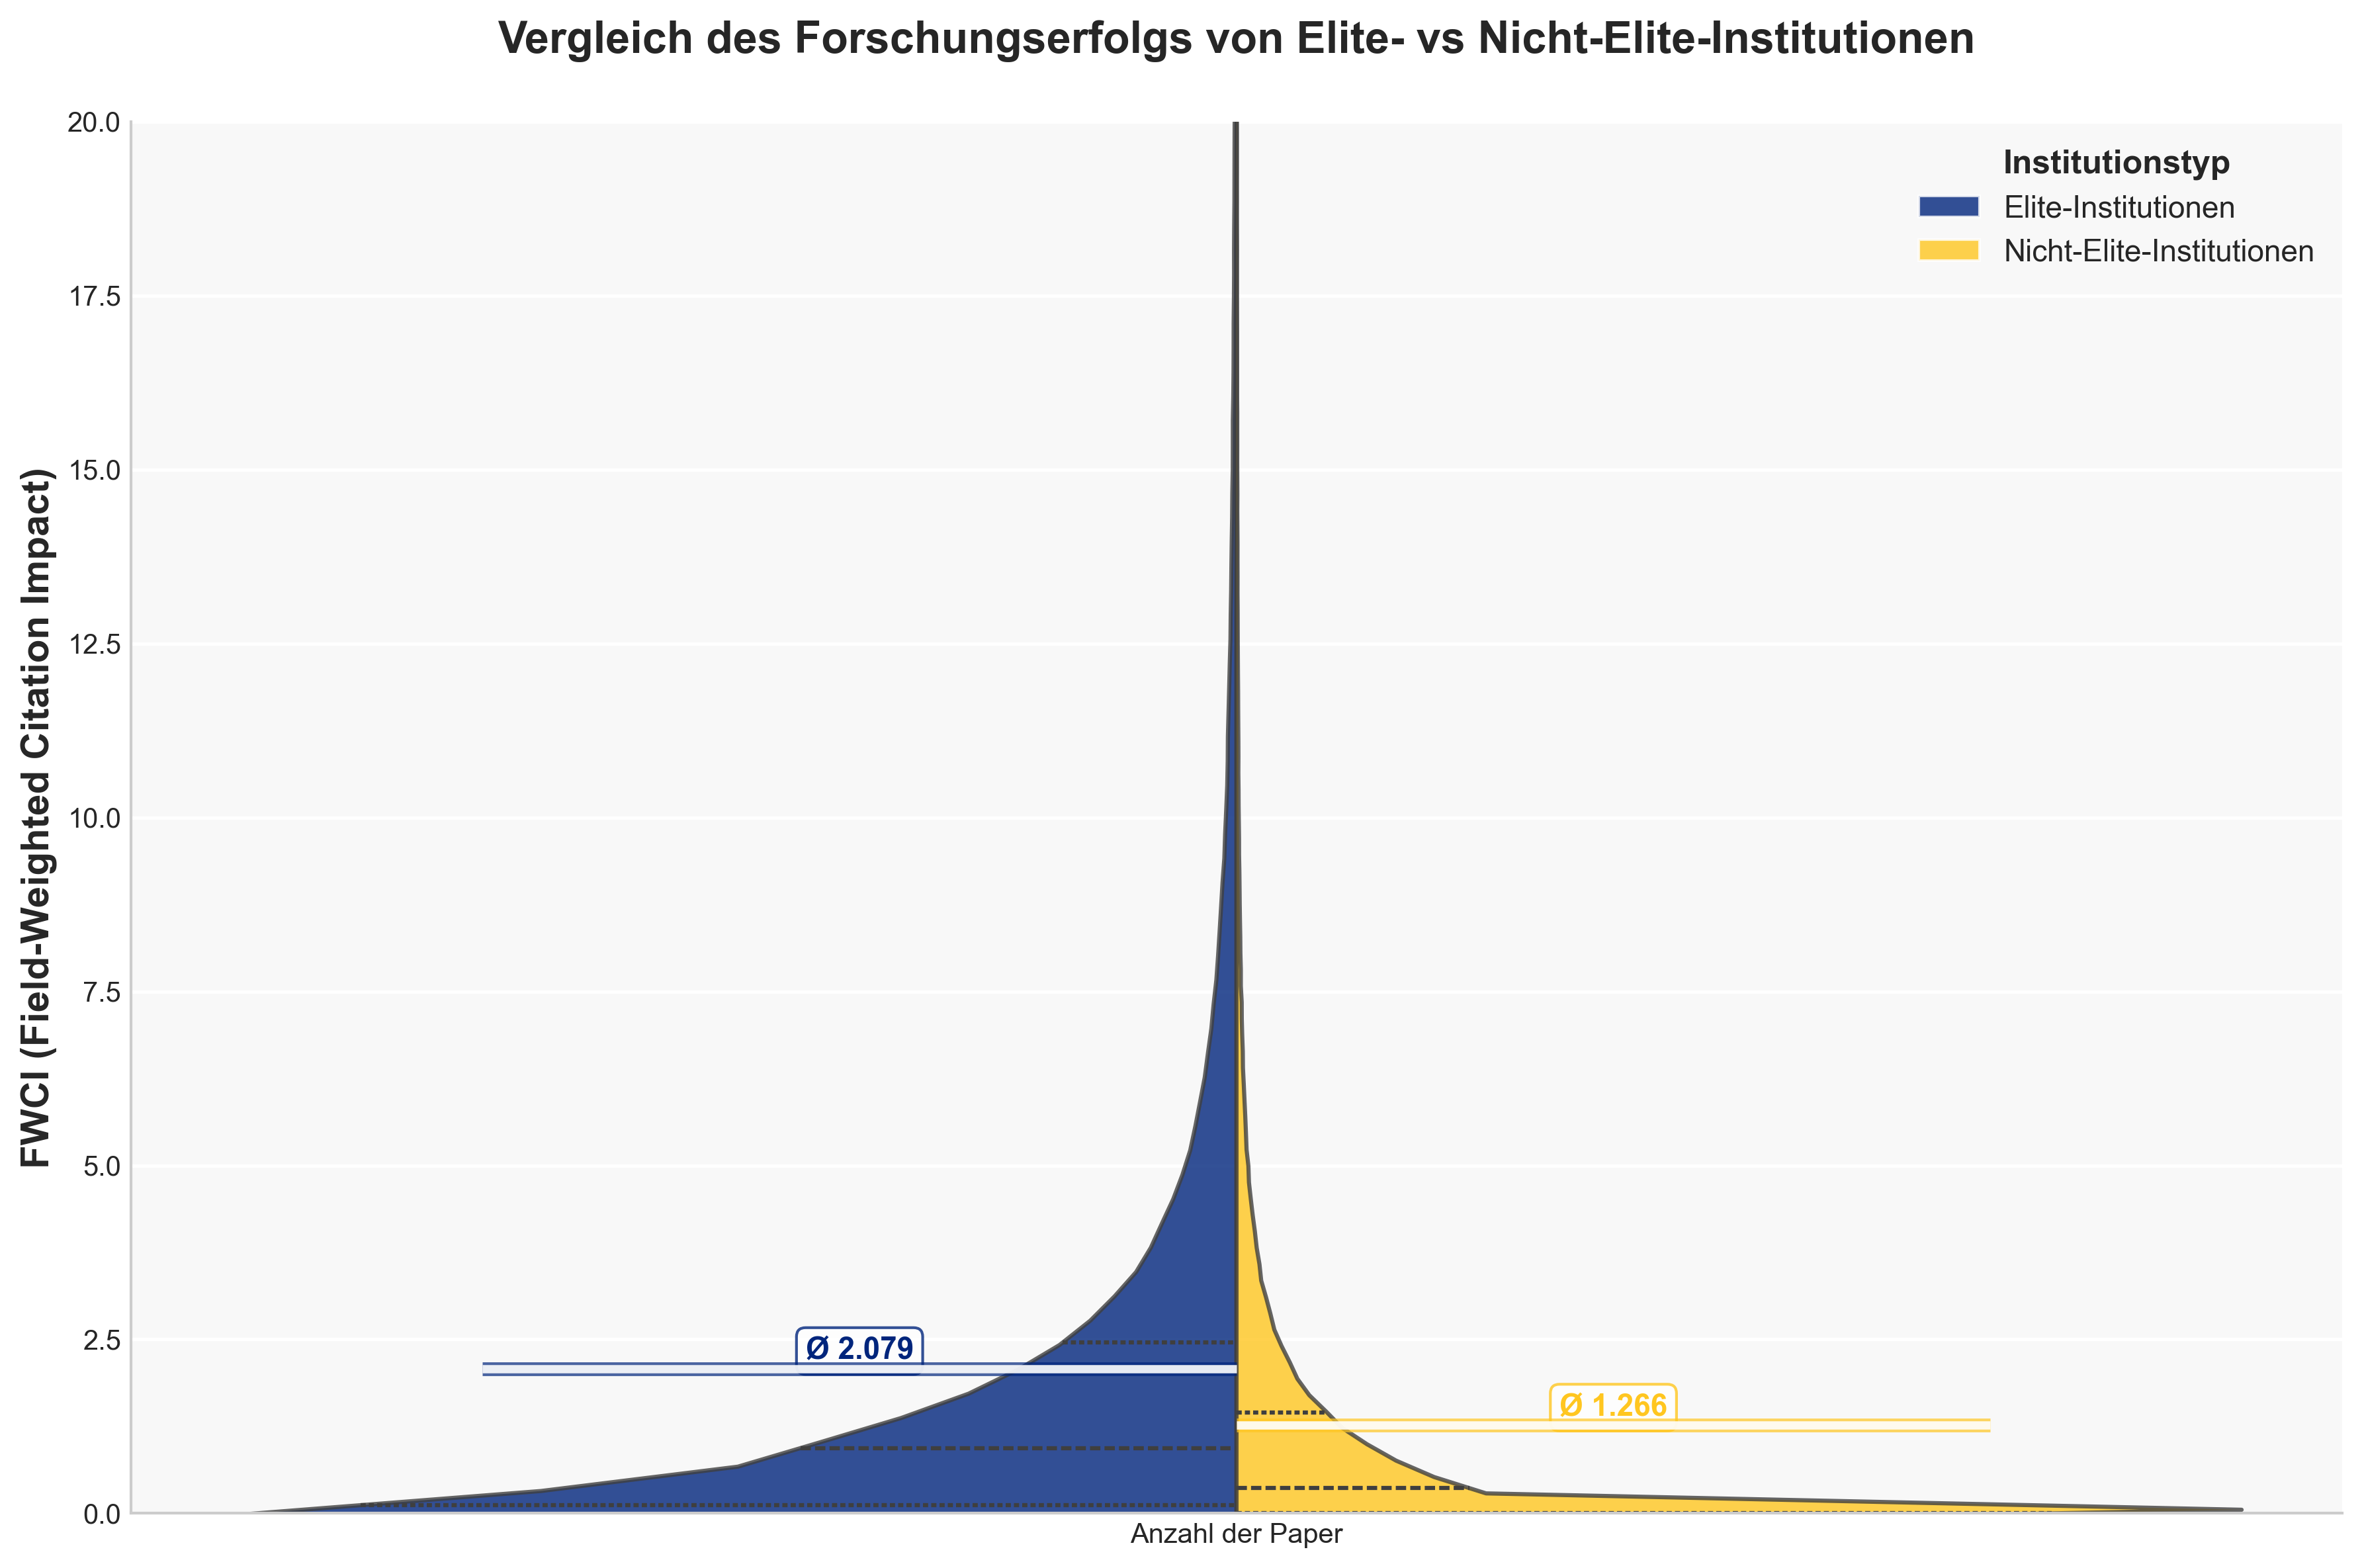

In [100]:
# Publikationsqualitäts-Farbpalette
base_colors = {
    'Elite-Institution': '#00257C',  # Dunkelblau
    'Sonstige Institution': '#FFC620',  # Orange/Gelb
}

# Plot erstellen
plt.figure(figsize=(12, 8), dpi=300)
ax = plt.axes()

# Hintergrund anpassen
ax.set_facecolor('#f8f8f8')
ax.grid(color='white', linestyle='-', linewidth=1.2)
ax.set_axisbelow(True)  # Grid hinter den Daten

# Violin Plot erstellen
violin_plot = sns.violinplot(
    data=plot_df,
    x='Kategorie',
    y='FWCI',
    hue='Institution',
    split=True,
    inner='quartile',
    density_norm="count",
    linewidth=1.5,
    ax=ax
)

# Farben anpassen
for i, collection in enumerate(ax.collections):
    if i % 2 == 0:  # Elite
        collection.set_facecolor(base_colors['Elite-Institution'])
        collection.set_alpha(0.8)
    else:  # Non-Elite
        collection.set_facecolor(base_colors['Sonstige Institution'])
        collection.set_alpha(0.8)

# Durchschnittswerte als horizontale Linien hinzufügen
# Position der Violin-Plots bestimmen
x_pos = 0  # Da wir nur eine Kategorie haben
violin_width = 0.3  # Breite der Violin Hälften

# Elite-Durchschnitt (linke Seite)
elite_line = ax.hlines(y=elite_mean, xmin=x_pos-violin_width, xmax=x_pos, 
                        colors='white', linewidth=3, linestyles='-', alpha=0.9, zorder=10)
elite_line_border = ax.hlines(y=elite_mean, xmin=x_pos-violin_width, xmax=x_pos, 
                                colors=base_colors['Elite-Institution'], linewidth=5, linestyles='-', alpha=0.7, zorder=9)

# Nicht-Elite-Durchschnitt (rechte Seite)
non_elite_line = ax.hlines(y=non_elite_mean, xmin=x_pos, xmax=x_pos+violin_width, 
                            colors='white', linewidth=3, linestyles='-', alpha=0.9, zorder=10)
non_elite_line_border = ax.hlines(y=non_elite_mean, xmin=x_pos, xmax=x_pos+violin_width, 
                                    colors=base_colors['Sonstige Institution'], linewidth=5, linestyles='-', alpha=0.7, zorder=9)

# Durchschnittswerte als Text hinzufügen
ax.text(x_pos-violin_width/2, elite_mean + 0.05, f'Ø {elite_mean:.3f}', 
        ha='center', va='bottom', fontsize=11, fontweight='bold', 
        color=base_colors['Elite-Institution'], 
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=base_colors['Elite-Institution']))

ax.text(x_pos+violin_width/2, non_elite_mean + 0.05, f'Ø {non_elite_mean:.3f}', 
        ha='center', va='bottom', fontsize=11, fontweight='bold', 
        color=base_colors['Sonstige Institution'],
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor=base_colors['Sonstige Institution']))

# Beschriftungen und Stil
plt.title("Vergleich des Forschungserfolgs von Elite- vs Nicht-Elite-Institutionen", 
            fontsize=16, fontweight='bold', pad=25)
plt.ylabel("FWCI (Field-Weighted Citation Impact)", fontsize=14, fontweight='bold')
plt.xlabel("", fontsize=12)

# Achsen anpassen
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.0)
ax.spines['bottom'].set_linewidth(1.0)

# Y-Achsenlimit anpassen
ymax = max(max(elite_cleaned), max(non_elite_cleaned)) 
plt.ylim(0, min(ymax, 20))  # Cap bei 5 für bessere Lesbarkeit

# Benutzerdefinierte Legende
legend_elements = [
    Patch(facecolor=base_colors['Elite-Institution'], edgecolor='white', alpha=0.8, 
            label=f'Elite-Institutionen'),
    Patch(facecolor=base_colors['Sonstige Institution'], edgecolor='white', alpha=0.8,
            label=f'Nicht-Elite-Institutionen')
]

legend = plt.legend(handles=legend_elements, loc='upper right', 
                    title='Institutionstyp', framealpha=0.95, edgecolor='lightgray',
                    title_fontsize=12, fontsize=11)
plt.setp(legend.get_title(), fontweight='bold')

plt.tight_layout()

# Plot als SVG speichern
plt.savefig(f"data/output/Hypothese_3.svg", 
            format='svg', bbox_inches='tight')

plt.show()

## Statistische Auswertung

### Korrelationsanalyse

In [ ]:
# Student's t-Test (parametrisch)
t_stat, p_value = stats.ttest_ind(original_elite, original_non_elite)

# Welch's t-test (ungleiche Varianzen)
welch_stat, welch_p = stats.ttest_ind(original_elite, original_non_elite, equal_var=False)

# Mann-Whitney U Test (non-parametrisch)
mannwhitney_stat, mannwhitney_p = stats.mannwhitneyu(original_elite, original_non_elite, alternative='two-sided')

# Effektstärke (Cohen's d)
pooled_std = np.sqrt(((len(original_elite)-1)*np.var(original_elite, ddof=1) + 
                        (len(original_non_elite)-1)*np.var(original_non_elite, ddof=1)) / 
                    (len(original_elite)+len(original_non_elite)-2))
cohens_d = (np.mean(original_elite) - np.mean(original_non_elite)) / pooled_std

print(f"Student's t-Test:")
print(f"  t-Statistik: {t_stat:.3f}")
print(f"  p-Wert: {p_value:.6f}")

print(f"\nWelch's t-Test (ungleiche Varianzen):")
print(f"  t-Statistik: {welch_stat:.3f}")
print(f"  p-Wert: {welch_p:.6f}")

print(f"\nMann-Whitney U Test (non-parametrisch):")
print(f"     U-Statistik: {mannwhitney_stat:.0f}")
print(f"     p-Wert: {mannwhitney_p:.6f}")

print(f"\nPooled Standardabweichung: {pooled_std:.3f}")
print(f"Effektstärke (Cohen's d): {cohens_d:.3f}")

Student's t-Test:
  t-Statistik: 182.742
  p-Wert: 0.000000

Welch's t-Test (ungleiche Varianzen):
  t-Statistik: 155.350
  p-Wert: 0.000000

Mann-Whitney U Test (non-parametrisch):
     U-Statistik: 15752756718557
     p-Wert: 0.000000

Pooled Standardabweichung: 6.831
Effektstärke (Cohen's d): 0.136


### Deskriptive Statistik

In [ ]:
print(f"Elite Universitäten:")
print(f"     Anzahl Papers: {len(original_elite):,}")
print(f"     Mittelwert: {np.mean(original_elite):.3f}")
print(f"     Median: {np.median(original_elite):.3f}")
print(f"     Standardabweichung: {np.std(original_elite):.3f}")
print(f"     Min: {np.min(original_elite):.3f}")
print(f"     Max: {np.max(original_elite):.3f}")

Elite Universitäten:
     Anzahl Papers: 2,098,210
     Mittelwert: 2.421
     Median: 0.948
     Standardabweichung: 8.260
     Min: 0.000
     Max: 2503.439


In [ ]:
print(f"Nicht-Elite Universitäten:")
print(f"     Anzahl Papers: {len(original_non_elite):,}")
print(f"     Mittelwert: {np.mean(original_non_elite):.3f}")
print(f"     Median: {np.median(original_non_elite):.3f}")
print(f"     Standardabweichung: {np.std(original_non_elite):.3f}")
print(f"     Min: {np.min(original_non_elite):.3f}")
print(f"     Max: {np.max(original_non_elite):.3f}")

Nicht-Elite Universitäten:
     Anzahl Papers: 12,379,617
     Mittelwert: 1.489
     Median: 0.371
     Standardabweichung: 6.558
     Min: 0.000
     Max: 8154.949


In [106]:
# Quartile
elite_q1, elite_q3 = np.percentile(original_elite, [25, 75])
non_elite_q1, non_elite_q3 = np.percentile(original_non_elite, [25, 75])

print(f"Quartile:")
print(f"   Elite Q1: {elite_q1:.3f}, Q3: {elite_q3:.3f} (IQR: {elite_q3-elite_q1:.3f})")
print(f"   Nicht-Elite Q1: {non_elite_q1:.3f}, Q3: {non_elite_q3:.3f} (IQR: {non_elite_q3-non_elite_q1:.3f})")

Quartile:
   Elite Q1: 0.121, Q3: 2.489 (IQR: 2.368)
   Nicht-Elite Q1: 0.000, Q3: 1.482 (IQR: 1.482)


In [109]:
# Vergleich
difference = np.mean(original_elite) - np.mean(original_non_elite)
percentage_diff = (difference / np.mean(original_non_elite) * 100)

# Signifikanz-Symbol
if p_value < 0.001:
    significance = "***"
elif p_value < 0.01:
    significance = "**"
elif p_value < 0.05:
    significance = "*"
else:
    significance = "n.s."

print(f"Vergleich:")
print(f"   Differenz Mittelwerte: {difference:.3f} {significance}")
print(f"   Prozentuale Differenz: {percentage_diff:.1f}%")
print(f"   Effektstärke (Cohen's d): {cohens_d:.3f}")

Vergleich:
   Differenz Mittelwerte: 0.932 ***
   Prozentuale Differenz: 62.6%
   Effektstärke (Cohen's d): 0.136


In [112]:
# Performance-Analysen
elite_above_1 = sum(1 for x in original_elite if x > 1.0) / len(original_elite) * 100
non_elite_above_1 = sum(1 for x in original_non_elite if x > 1.0) / len(original_non_elite) * 100

elite_top = sum(1 for x in original_elite if x > 2.0) / len(original_elite) * 100
non_elite_top = sum(1 for x in original_non_elite if x > 2.0) / len(original_non_elite) * 100

print(f"Performance Analyse:")
print(f"   Anteil Papers mit FWCI > 1.0 (überdurchschnittlich):")
print(f"     Elite: {elite_above_1:.1f}%")
print(f"     Nicht-Elite: {non_elite_above_1:.1f}%")
print(f"     Differenz: {elite_above_1 - non_elite_above_1:.1f} Prozentpunkte")

print(f"\nAnteil Top-Performer (FWCI > 2.0):")
print(f"     Elite: {elite_top:.1f}%")
print(f"     Nicht-Elite: {non_elite_top:.1f}%")
print(f"     Differenz: {elite_top - non_elite_top:.1f} Prozentpunkte")

Performance Analyse:
   Anteil Papers mit FWCI > 1.0 (überdurchschnittlich):
     Elite: 48.8%
     Nicht-Elite: 33.1%
     Differenz: 15.8 Prozentpunkte

Anteil Top-Performer (FWCI > 2.0):
     Elite: 30.7%
     Nicht-Elite: 19.2%
     Differenz: 11.5 Prozentpunkte
